# Imports and Setup

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import glob
import re

# Models
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Tools
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_selection import SelectKBest, f_regression

# Setup
sns.set_style("whitegrid")
if not os.path.exists("../../models"):
    os.makedirs("../../models")

## 1. Data Loading & Cleaning
We load the cleaned **Advertising (User)** dataset.
* **Target:** `conversion_rate`
* **Action:** We remove any non-numeric columns and ensure missing values are handled.

In [31]:
# FIND FILE AUTOMATICALLY
# Note: Adjust "../" if your notebook is in a different subfolder
files = glob.glob("../Cleaned_Datasets/Advertising/*.csv")
print(f"Loading file: {files[0]}")
df = pd.read_csv(files[0])

# DEFINE TARGET
TARGET = 'conversion_rate'

# PRE-PROCESSING
# Drop non-predictive columns (IDs, timestamps if not converted)
drop_cols = ['ROI'] # ROI is calculated AFTER conversion, so it's a cheat/leak.
df = df.drop([c for c in drop_cols if c in df.columns], axis=1)

# Basic Encoding (if any object columns remain)
df = pd.get_dummies(df, drop_first=True)
df = df.fillna(0)

print(f"Final Data Shape: {df.shape}")

Loading file: ../Cleaned_Datasets/Advertising\advertising_v1_hours_only.csv
Final Data Shape: (1000, 25)


## 2. Feature Selection
To improve model performance and reduce noise, we "play" with features using:
1.  **Correlation Matrix:** Visualizing linear relationships.
2.  **SelectKBest:** Statistical test to pick the top 10 most influential features.

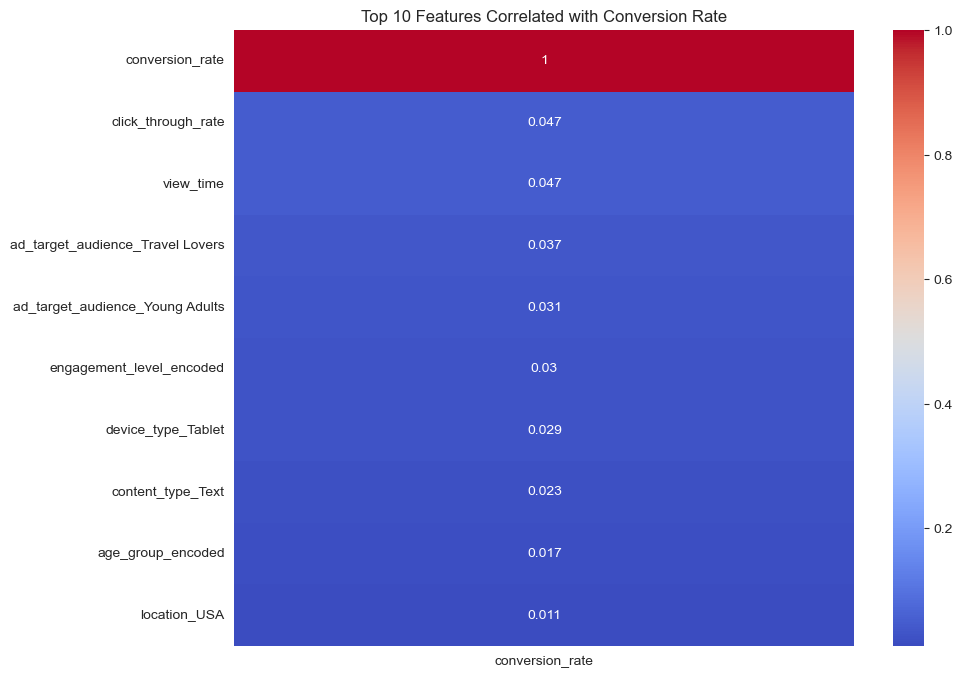

✅ Column names sanitized for LightGBM.
✅ Features ready: 24
✅ Selected Features: ['Unnamed__0', 'click_through_rate', 'view_time', 'cost_per_click', 'engagement_level_encoded', 'device_type_Tablet', 'gender_Male', 'content_type_Video', 'ad_target_audience_Travel_Lovers', 'ad_target_audience_Young_Adults']


In [32]:
# 1. VISUALIZE CORRELATIONS
plt.figure(figsize=(10, 8))
corr = df.corr()
sns.heatmap(corr[[TARGET]].sort_values(by=TARGET, ascending=False).head(10), annot=True, cmap='coolwarm')
plt.title("Top 10 Features Correlated with Conversion Rate")
plt.show()

# 2. SELECT BEST FEATURES
X = df.drop(TARGET, axis=1)
y = df[TARGET]

X.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in X.columns]
print("✅ Column names sanitized for LightGBM.")
# ==============================================================================

# 3. SELECT BEST FEATURES 
selector = SelectKBest(score_func=f_regression, k='all') 
selector.fit(X, y)

selected_features = X.columns[selector.get_support()]
print(f"✅ Features ready: {len(selected_features)}")

# Select Top 10 Features
selector = SelectKBest(score_func=f_regression, k=10) # Change k to play with number of features
selector.fit(X, y)

selected_features = X.columns[selector.get_support()]
print(f"✅ Selected Features: {list(selected_features)}")

# UPDATE DATA TO USE ONLY SELECTED FEATURES
# Uncomment the line below to enforce selection, or leave commented to use ALL features
# X = X[selected_features]

## 3. Baseline Model Comparison
We train three "classical" models with default parameters to establish a baseline.
* Random Forest
* XGBoost
* LightGBM

In [33]:
# SPLIT DATA
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    'RandomForest': RandomForestRegressor(random_state=42, n_estimators=100),
    'XGBoost': XGBRegressor(random_state=42, objective='reg:squarederror'),
    'LightGBM': LGBMRegressor(random_state=42, verbose=-1)
}

best_r2 = -float('inf')
best_model_name = ""
best_base_model = None

print(f"{'Model':<15} | {'R2 Score':<10} | {'RMSE':<10}")
print("-" * 40)

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    print(f"{name:<15} | {r2:.4f}     | {rmse:.4f}")
    
    if r2 > best_r2:
        best_r2 = r2
        best_model_name = name
        best_base_model = model

print(f"\n🏆 Winner: {best_model_name}")

Model           | R2 Score   | RMSE      
----------------------------------------
RandomForest    | -0.0255     | 0.0400
XGBoost         | -0.2740     | 0.0446
LightGBM        | -0.1751     | 0.0428

🏆 Winner: RandomForest


## 4. Hyperparameter Optimization
We take the winning model and optimize it using `RandomizedSearchCV`.

In [34]:
# Define grids for all models (generic)
param_grids = {
    'RandomForest': {'n_estimators': [100, 300], 'max_depth': [10, 20, None]},
    'XGBoost': {'n_estimators': [100, 300], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 5]},
    'LightGBM': {'n_estimators': [100, 300], 'learning_rate': [0.01, 0.1], 'num_leaves': [31, 50]}
}

print(f"Optimizing {best_model_name}...")
params = param_grids[best_model_name]

# Initialize Random Search
search = RandomizedSearchCV(
    estimator=best_base_model,
    param_distributions=params,
    n_iter=10,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42
)

search.fit(X_train, y_train)
best_opt_model = search.best_estimator_

# Evaluate Optimized Model
y_pred_opt = best_opt_model.predict(X_test)
opt_r2 = r2_score(y_test, y_pred_opt)

print(f"Base R2: {best_r2:.4f}")
print(f"Optimized R2: {opt_r2:.4f}")

Optimizing RandomForest...


c:\Users\gonal\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Base R2: -0.0255
Optimized R2: -0.0086


# Saving the model

In [35]:
from datetime import datetime
timestamp = datetime.now().strftime("%Y%m%d_%H%M")

# Save file with Score in name
filename = f"Engine_A_User_{best_model_name}_R2-{opt_r2:.3f}_{timestamp}.joblib"
save_path = os.path.join("../models", filename)

joblib.dump(best_opt_model, save_path)
print(f"✅ Model saved: {save_path}")

✅ Model saved: ../models\Engine_A_User_RandomForest_R2--0.009_20260110_1908.joblib
